# Basketball Lineup Plus-minus Prediction Via Regression


## Introduction 

In basketball, there is a statistic called the “plus-minus” (short-handed to “+/-”) that refers to the sum of all of the points scored while they were on the court, minus the sum of all the points they let the opposing team score. This statistic is a good quantifiable value for the overall effect of a line in a basketball game, and it can be used to determine the best line for a team to play in a game. In our project, our group is trying to approximate the plus-minus of a certain line in a basketball game using the general statistics of a line during a game.

Our dataset contains the statistics of various NBA lineups. In every row of our dataset, there are the team names, players in a certain lineup, and all recorded statistics during the game such as the points scored, three-point shots made, minutes played, etc.

## Preliminary exploratory data analysis

In [10]:
library(tidyverse)
library(tidymodels)

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Dig deeper into tidy modeling with R at https://www.tmwr.org



Rows: 250 Columns: 30
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (6): TEAM, First Player, Second Player, Third Player, Fourth Player, Fi...
dbl (24): ...1, GP, MIN, PTS, FGM, FGA, FG%, 3PM, 3PA, 3P%, FTM, FTA, FT%, O...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


GP,MIN,PTS,FGM,FGA,FGP,3PM,3PA,3P%,FTM,⋯,TOV,STL,BLK,BLKA,PF,PFD,P_M,PIR,TSP,PPP
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
41,21.5,46.3,17.6,37.2,47.4,3.2,9.1,35.5,7.9,⋯,6.4,3.2,2.0,2.2,7.8,8.9,-0.9,52.5,0.5564904,0.9645833
28,14.1,30.5,12.1,26.6,45.6,2.4,6.0,39.6,3.9,⋯,3.6,1.6,1.6,1.5,4.9,4.7,-1.6,32.9,0.5295139,0.9413580
6,13.1,29.7,11.0,22.3,49.3,3.5,7.3,47.7,4.2,⋯,4.7,3.3,1.0,1.2,5.3,5.8,-4.3,31.8,0.6039531,1.0140672
30,13.0,27.9,10.7,23.1,46.5,2.1,6.7,31.7,4.3,⋯,3.5,1.9,1.9,1.1,5.4,5.0,-0.9,30.6,0.5410332,0.9527387
7,12.6,24.7,9.4,21.0,44.9,2.9,7.9,36.4,3.0,⋯,5.4,2.3,0.9,0.4,4.7,3.4,-5.1,24.3,0.5436697,0.8785033


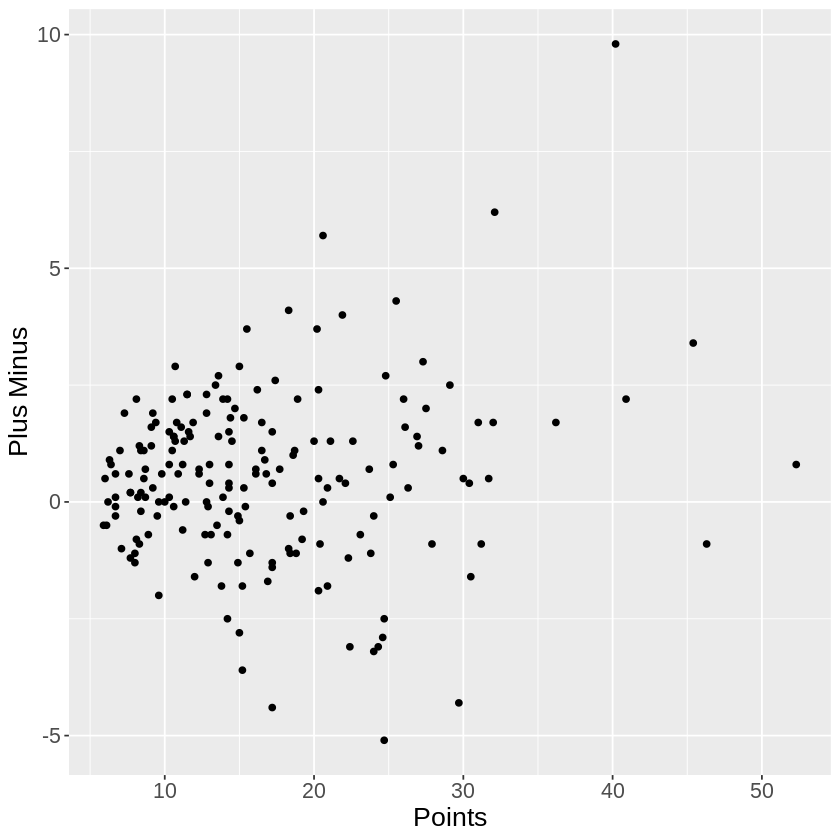

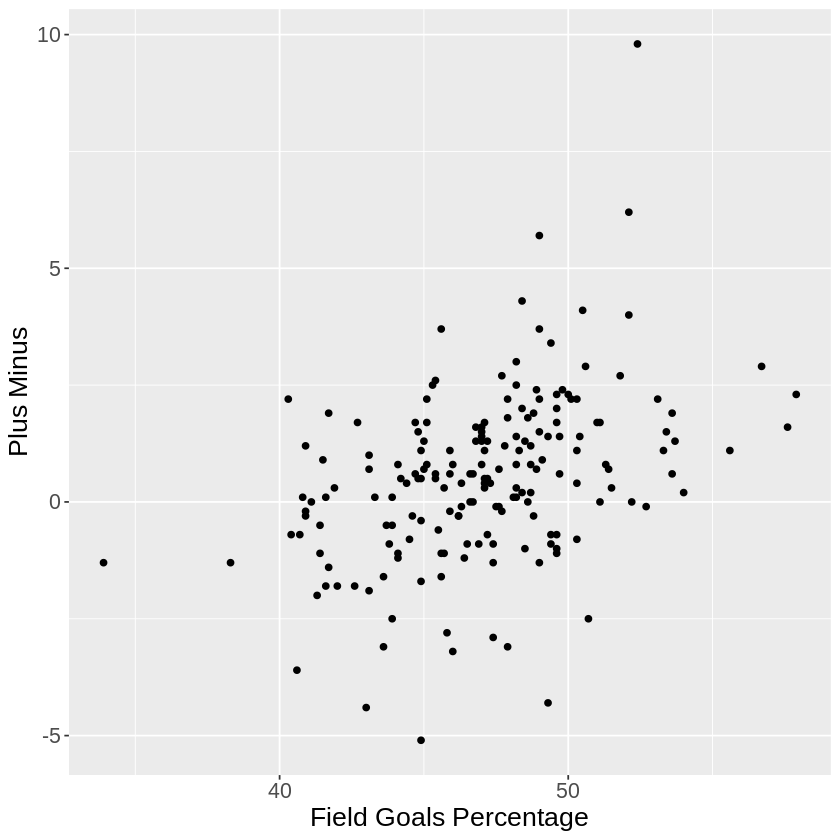

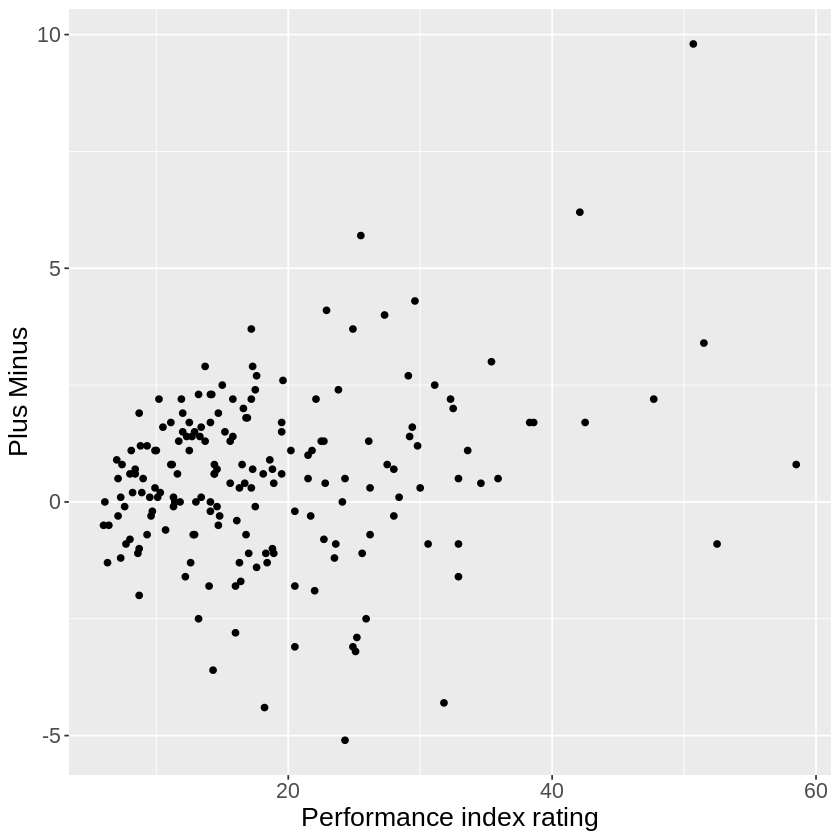

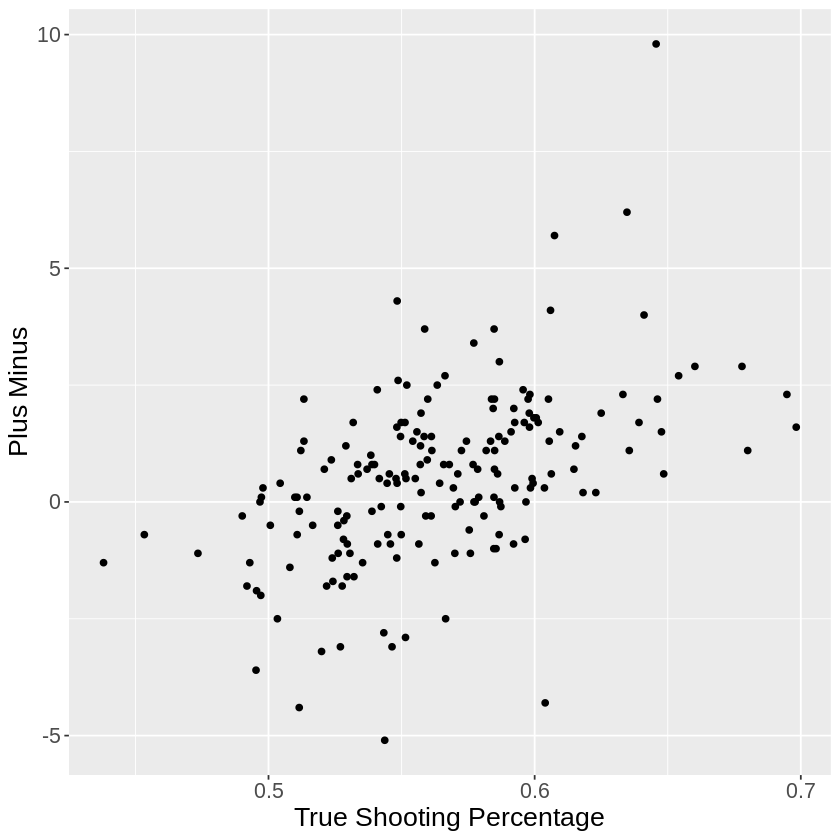

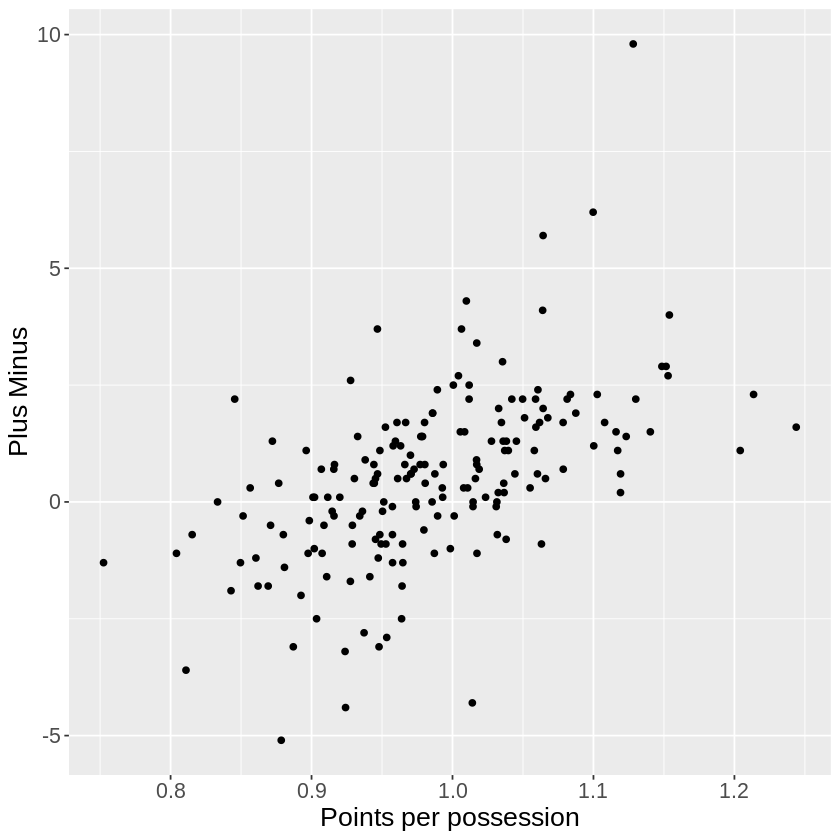

In [19]:
lineup_stat <- read_csv("https://raw.githubusercontent.com/JerryQi77/DSCI_Group-Project/main/DSCI_Group_project?token=GHSAT0AAAAAABZQJWZPOUAKKT7OY7UAZ33IY2546GQ")

colnames(lineup_stat)[colnames(lineup_stat) == "+/-"] <- "P_M"
colnames(lineup_stat)[colnames(lineup_stat) == "FG%"] <- "FGP"
lineup_stat <- select(lineup_stat, GP:P_M)

lineup_stat <- lineup_stat |>
                 mutate(PIR = PTS + REB + AST + STL + BLK + PFD + FGM - FGA + FTM - FTA - TOV - BLKA - PF) |>
                 mutate(TSP = PTS / ((2 * FGA) + (0.88 * FTA))) |>
                 mutate(PPP = PTS / (FGA + (0.44 * FTA) + TOV))

lineup_split <- initial_split(lineup_stat, prop = 0.75, strata = P_M)
lineup_train <- training(lineup_split)

lineup_train |>
   slice(1:5)

lineup_test <- testing(lineup_split)

pts_plot <- ggplot(lineup_train, aes(x = PTS, y = P_M)) + geom_point() +
            xlab("Points") + ylab("Plus Minus") + theme(text = element_text(size=16))

fgp_plot <- ggplot(lineup_train, aes(x = FGP, y = P_M)) + geom_point() +
            xlab("Field Goals Percentage") + ylab("Plus Minus") + theme(text = element_text(size=16))

pir_plot <- ggplot(lineup_train, aes(x = PIR, y = P_M)) + geom_point() +
            xlab("Performance index rating") + ylab("Plus Minus") + theme(text = element_text(size=16))

tsp_plot <- ggplot(lineup_train, aes(x = TSP, y = P_M)) + geom_point() +
            xlab("True Shooting Percentage") + ylab("Plus Minus") + theme(text = element_text(size=16))

ppp_plot <- ggplot(lineup_train, aes(x = PPP, y = P_M)) + geom_point() +
            xlab("Points per possession") + ylab("Plus Minus") + theme(text = element_text(size=16))

pts_plot
fgp_plot
pir_plot
tsp_plot
ppp_plot

## Methods


We plan to use regression five times using different predictors and find out which is the best at predicting the plus-minus of a line.

##### The predictors we plan to use are listed below:

Normally people think the more points players get, or the higher hit rate players have, the more positive effect they will have so we will use PTS and FG% as two predictors.

For people who know more about basketball, they will consider Performance Index Ranking (PIR) (an addition index consisting of positive actions minus negative actions), True Shooting Percentage (TSP) (an index that balances points, field goal attempts, and free throw attempts), Points Per Possession (PPP) (an index calculates points per possession is an advanced statistic that attempts to measure the number of points a player generates for each possession of the ball) can influence the effect of players on the game, so we will use these three indexes as predictors.

Performance Index Ranking (PIR) is calculated using the following equation:

(Points + Rebounds + Assists + Steals + Blocks + Fouls Drawn) - (Missed Field Goals + Missed Free Throws + Turnovers + Shots Rejected + Fouls Committed)

We will visualize the data using a scatterplot with one of our five predictors on the x-axis, and the plus-minus of a line on the y-axis.

## Expected outcomes and significance:

During our project, we are expecting to find which one of our five predictors is the best at predicting the plus-minus of a line and therefore the overall effect the line has in a game. This information could give NBA Scouts and General Managers more insight into a player's performance and allow them to trade or draft players most beneficial to their team.

Some future questions that may be asked after our initial question is answered are:

- Is the Euroleague’s Performance Index Rating an accurate representation of the performance of a lineup in a game? It is used to scout and draft players in the Euroleague and with our initial question answered, we may be able to verify the accuracy of this index

- Does this reflect the overall teamwork between players or is this a reflection of the individual skills of each player on a team? Answering this question can show the effect a single "superstar" player can have on a single lineup.